# Exploration Notebook - Stopped Using

# Bayesian Change Point Analysis of COVID-19 Data

Apply the Bayesian changepoint analysis in Bayesian Methods for Hackers to COVID data

https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_TFP.ipynb

Blog posts and papers:
- http://gregorygundersen.com/blog/2019/08/13/bocd/
- https://arxiv.org/abs/0710.3742

Would be nice if this could be done in Pyro.

## Model

I want to see if I can back out the date virus growth changed, and test its accuracy against the social distancing measures. Depending on how close they are, we can determine how effective social distancing measures were in different countries.  

We have 2 options:

- Model the change in the virus as a change in the exponential growth rate constant: The problem I see here is that when we pass the threshold, we are not starting from $t=0$, so I don't know if this will affect the model. Also don't even know if we're starting at $t=0$, maybe we can start at $t=t$.
    
    
- Model the change in the virus as a change in the number of new cases each day: Tested this and the problem is that the Bayesian model does not know what the underlying data generating process is exponential, so we end up getting a date around when the virus bega. We need to incorporate the exponential growth model into the framework somehow.


### Exponential Growth Model for Virus

$$ y = e^{kt} $$

Where $y$ is the number of infected cases $t$ days after the first infected case and $k$ is the growth rate constant.


### Bayesian Change Point Model

Priors: 

$$ \lambda_1^{(0)} \sim Exp(\alpha) $$    
$$ \lambda_1^{(0)} \sim Exp(\alpha) $$

The change will most likely come at the middle / end of our data, so the prior on $\tau$ is weighted more to the right.

$$ \tau \sim Beta(4, 2) $$

Likelihood:

$$ X_i \sim Poi (rate = \lambda) $$

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from scipy import stats

In [2]:
data = pd.read_csv("/Users/jonny/Desktop/Dataset/covid_19_counts-april8.csv")

# use only canada for now
cad = data.loc[data["Country/Region"] == "Canada", ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
cad.columns = ["country", "date", "confirmed", "deaths", "recovered"]

# group by country and date, sum(confirmed, deaths, recovered)
cad = cad.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

# convert date string to datetime
cad.date = pd.to_datetime(cad.date)
cad = cad.sort_values(by = "date")

# weird data around April 5th, just remove for now:
cad = cad[cad.date < "2020-04-04"]

cad.tail()

/Users/jonny/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,country,date,confirmed,deaths,recovered
62,Canada,2020-03-30,7398,80,0
63,Canada,2020-03-31,8527,101,0
70,Canada,2020-04-01,9560,109,0
71,Canada,2020-04-02,11284,139,0
72,Canada,2020-04-03,12437,179,0


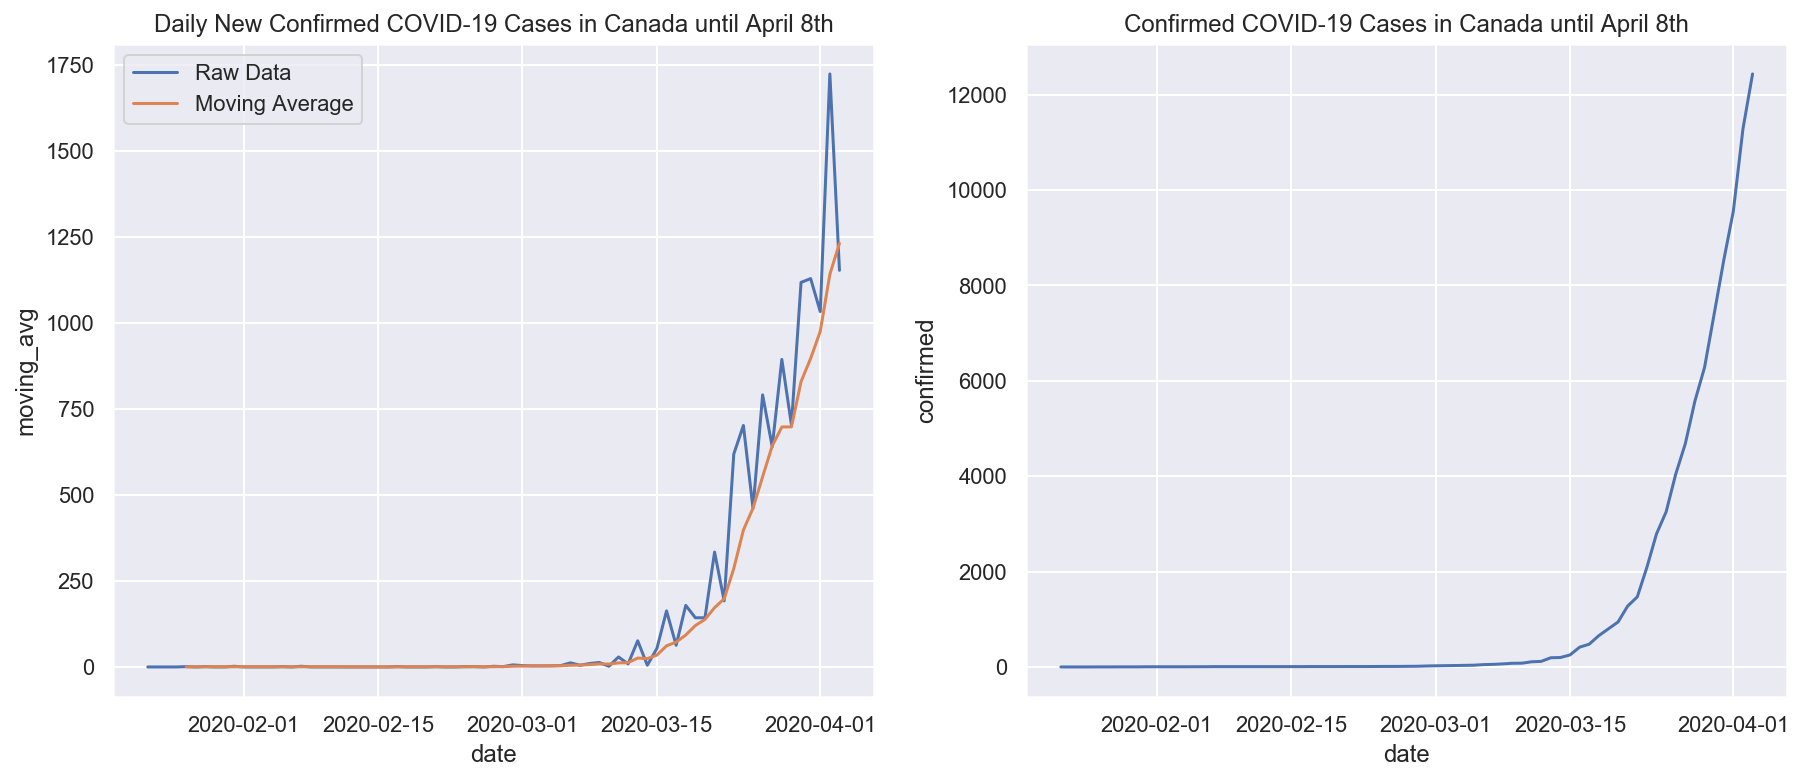

In [3]:
cases_shifted = np.array([0] + list(cad.confirmed[:-1]))
daily_confirmed = np.array(cad.confirmed) - cases_shifted
cad["daily_confirmed"] = daily_confirmed 

cad["moving_avg"] = cad.daily_confirmed.rolling(window=5).mean()

fig, ax = plt.subplots(1,2, figsize=(15, 6))

# plot daily confirmed cases, along with moving average
#plt.figure(figsize=(11, 5))
sns.lineplot(x = "date", 
             y = "daily_confirmed", 
             label = "Raw Data",
             data = cad,
             ax = ax[0])

sns.lineplot(x = "date", 
             y = "moving_avg", 
             data = cad,
             label = "Moving Average",
             legend = "full",
             ax = ax[0]).set_title("Daily New Confirmed COVID-19 Cases in Canada until April 8th")

sns.lineplot(x="date", 
             y="confirmed", 
             data= cad,
             ax = ax[1]
            ).set_title("Confirmed COVID-19 Cases in Canada until April 8th");

/Users/jonny/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


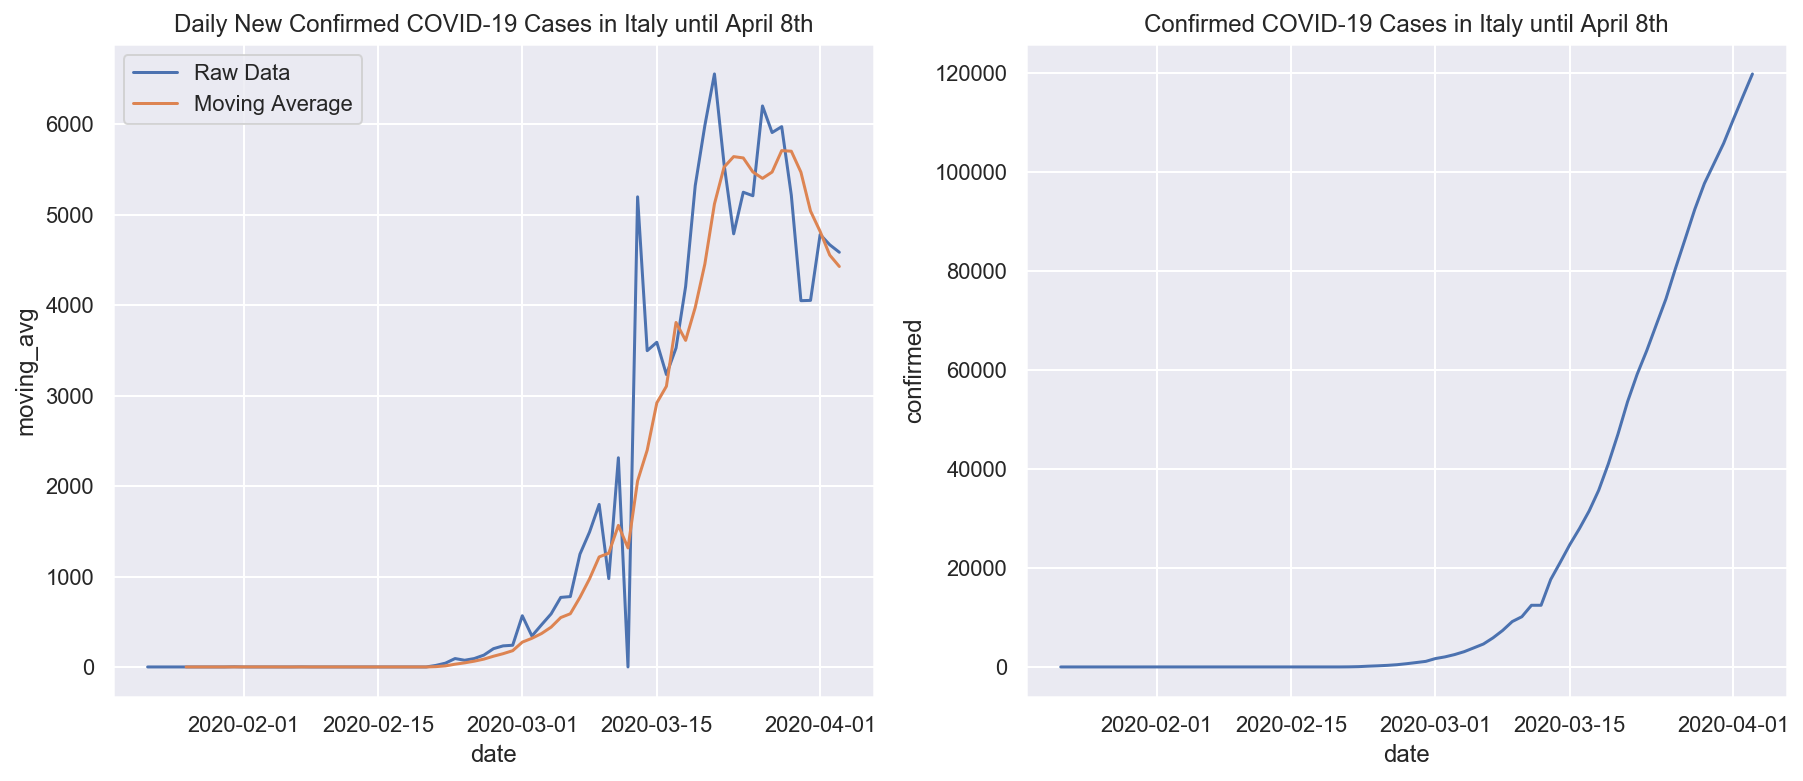

In [4]:
# italy

# use only canada for now
italy = data.loc[data["Country/Region"] == "Italy", ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
italy.columns = ["country", "date", "confirmed", "deaths", "recovered"]

# group by country and date, sum(confirmed, deaths, recovered)
italy = italy.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

# convert date string to datetime
italy.date = pd.to_datetime(cad.date)
italy = italy.sort_values(by = "date")

# weird data around April 5th, just remove for now:
#italy = italy[italy.date < "2020-04-04"]

italy.tail()

cases_shifted = np.array([0] + list(italy.confirmed[:-1]))
daily_confirmed = np.array(italy.confirmed) - cases_shifted
italy["daily_confirmed"] = daily_confirmed 

italy["moving_avg"] = italy.daily_confirmed.rolling(window=5).mean()

fig, ax = plt.subplots(1,2, figsize=(15, 6))

# plot daily confirmed cases, along with moving average
#plt.figure(figsize=(11, 5))
sns.lineplot(x = italy.date, 
             y = italy.daily_confirmed, 
             label = "Raw Data",
             ax = ax[0])

sns.lineplot(x = italy.date, 
             y = italy.moving_avg, 
             label = "Moving Average",
             legend = "full",
             ax = ax[0]).set_title("Daily New Confirmed COVID-19 Cases in Italy until April 8th")

sns.lineplot(x="date", 
             y="confirmed", 
             data= italy,
             ax = ax[1]
            ).set_title("Confirmed COVID-19 Cases in Italy until April 8th");

## TFP Model from BMH

In [149]:
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
matplotlib_style = 'fivethirtyeight' 
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors


class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

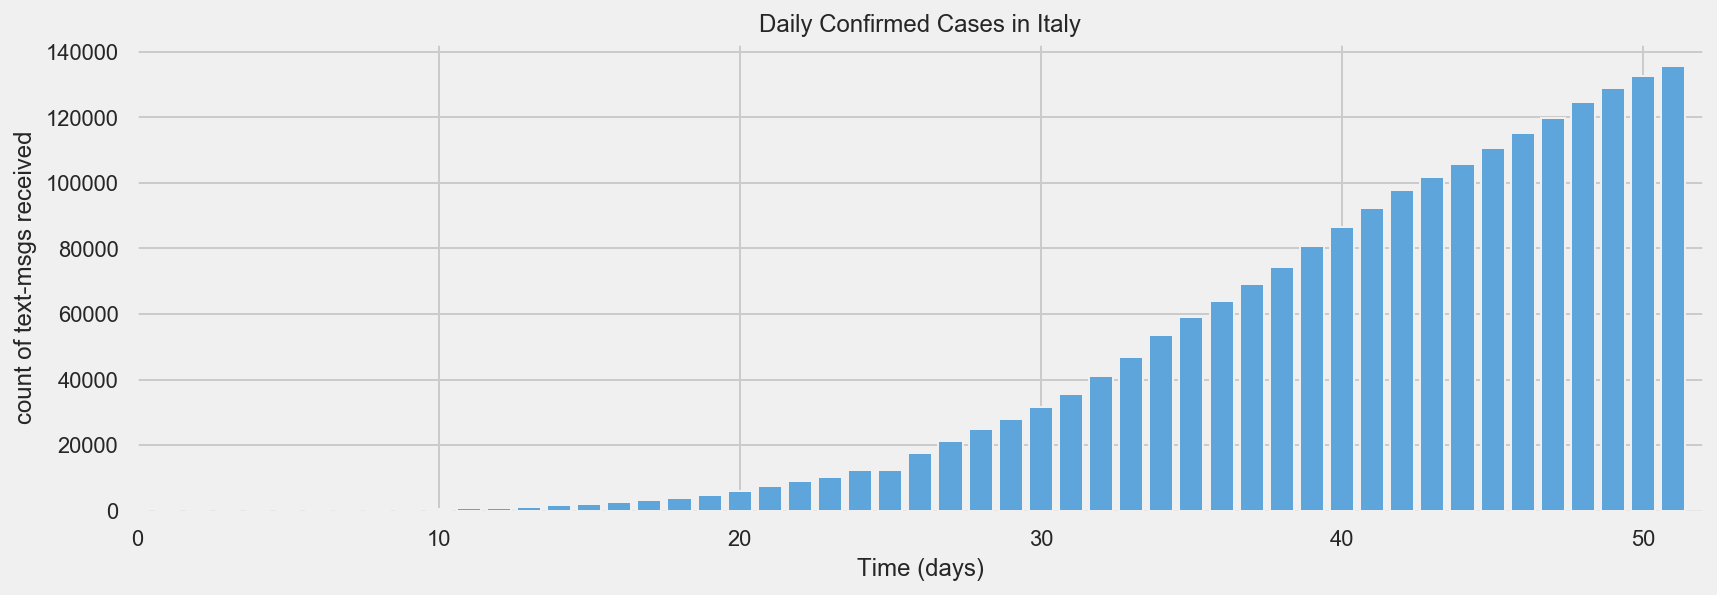

In [342]:
# Defining our Data and assumptions
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)

##### test new count data
#count_data = tf.constant(cad[cad.date > "2020-03-01"].daily_confirmed, dtype = tf.float32)
count_data = tf.constant(italy.confirmed[25:], dtype = tf.float32)

n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0],dtype=tf.int32)

# Visualizing the Results
plt.figure(figsize=(12.5, 4))
plt.bar(days.numpy(), count_data, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Daily Confirmed Cases in Italy")
plt.xlim(0, n_count_data[0].numpy());

In [343]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    alpha = (1. / tf.reduce_mean(count_data))
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    #rv_tau = tfd.Uniform()
    rv_tau = tfd.Beta(4, 2)
 
    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(tau * tf.cast(tf.size(count_data), dtype=tf.float32) <= tf.cast(tf.range(tf.size(count_data)), dtype=tf.float32), dtype=tf.int32))
    rv_observation = tfd.Poisson(rate=lambda_)
 
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )


# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)

In [344]:
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
    return tfp.mcmc.sample_chain(*args, **kwargs)

num_burnin_steps = 5000
num_results = 20000


# Set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

step_size = 0.2

kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))


# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = graph_sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_chain_state,
    kernel = kernel)
    
tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data),dtype=tf.float32))

In [345]:
print("acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(kernel_results.inner_results.inner_results.is_accepted,dtype=tf.float32))))
print("final step size: {}".format(
    tf.reduce_mean(kernel_results.inner_results.inner_results.accepted_results.step_size[-100:])))

acceptance rate: 0.49904999136924744
final step size: 0.0013014193391427398


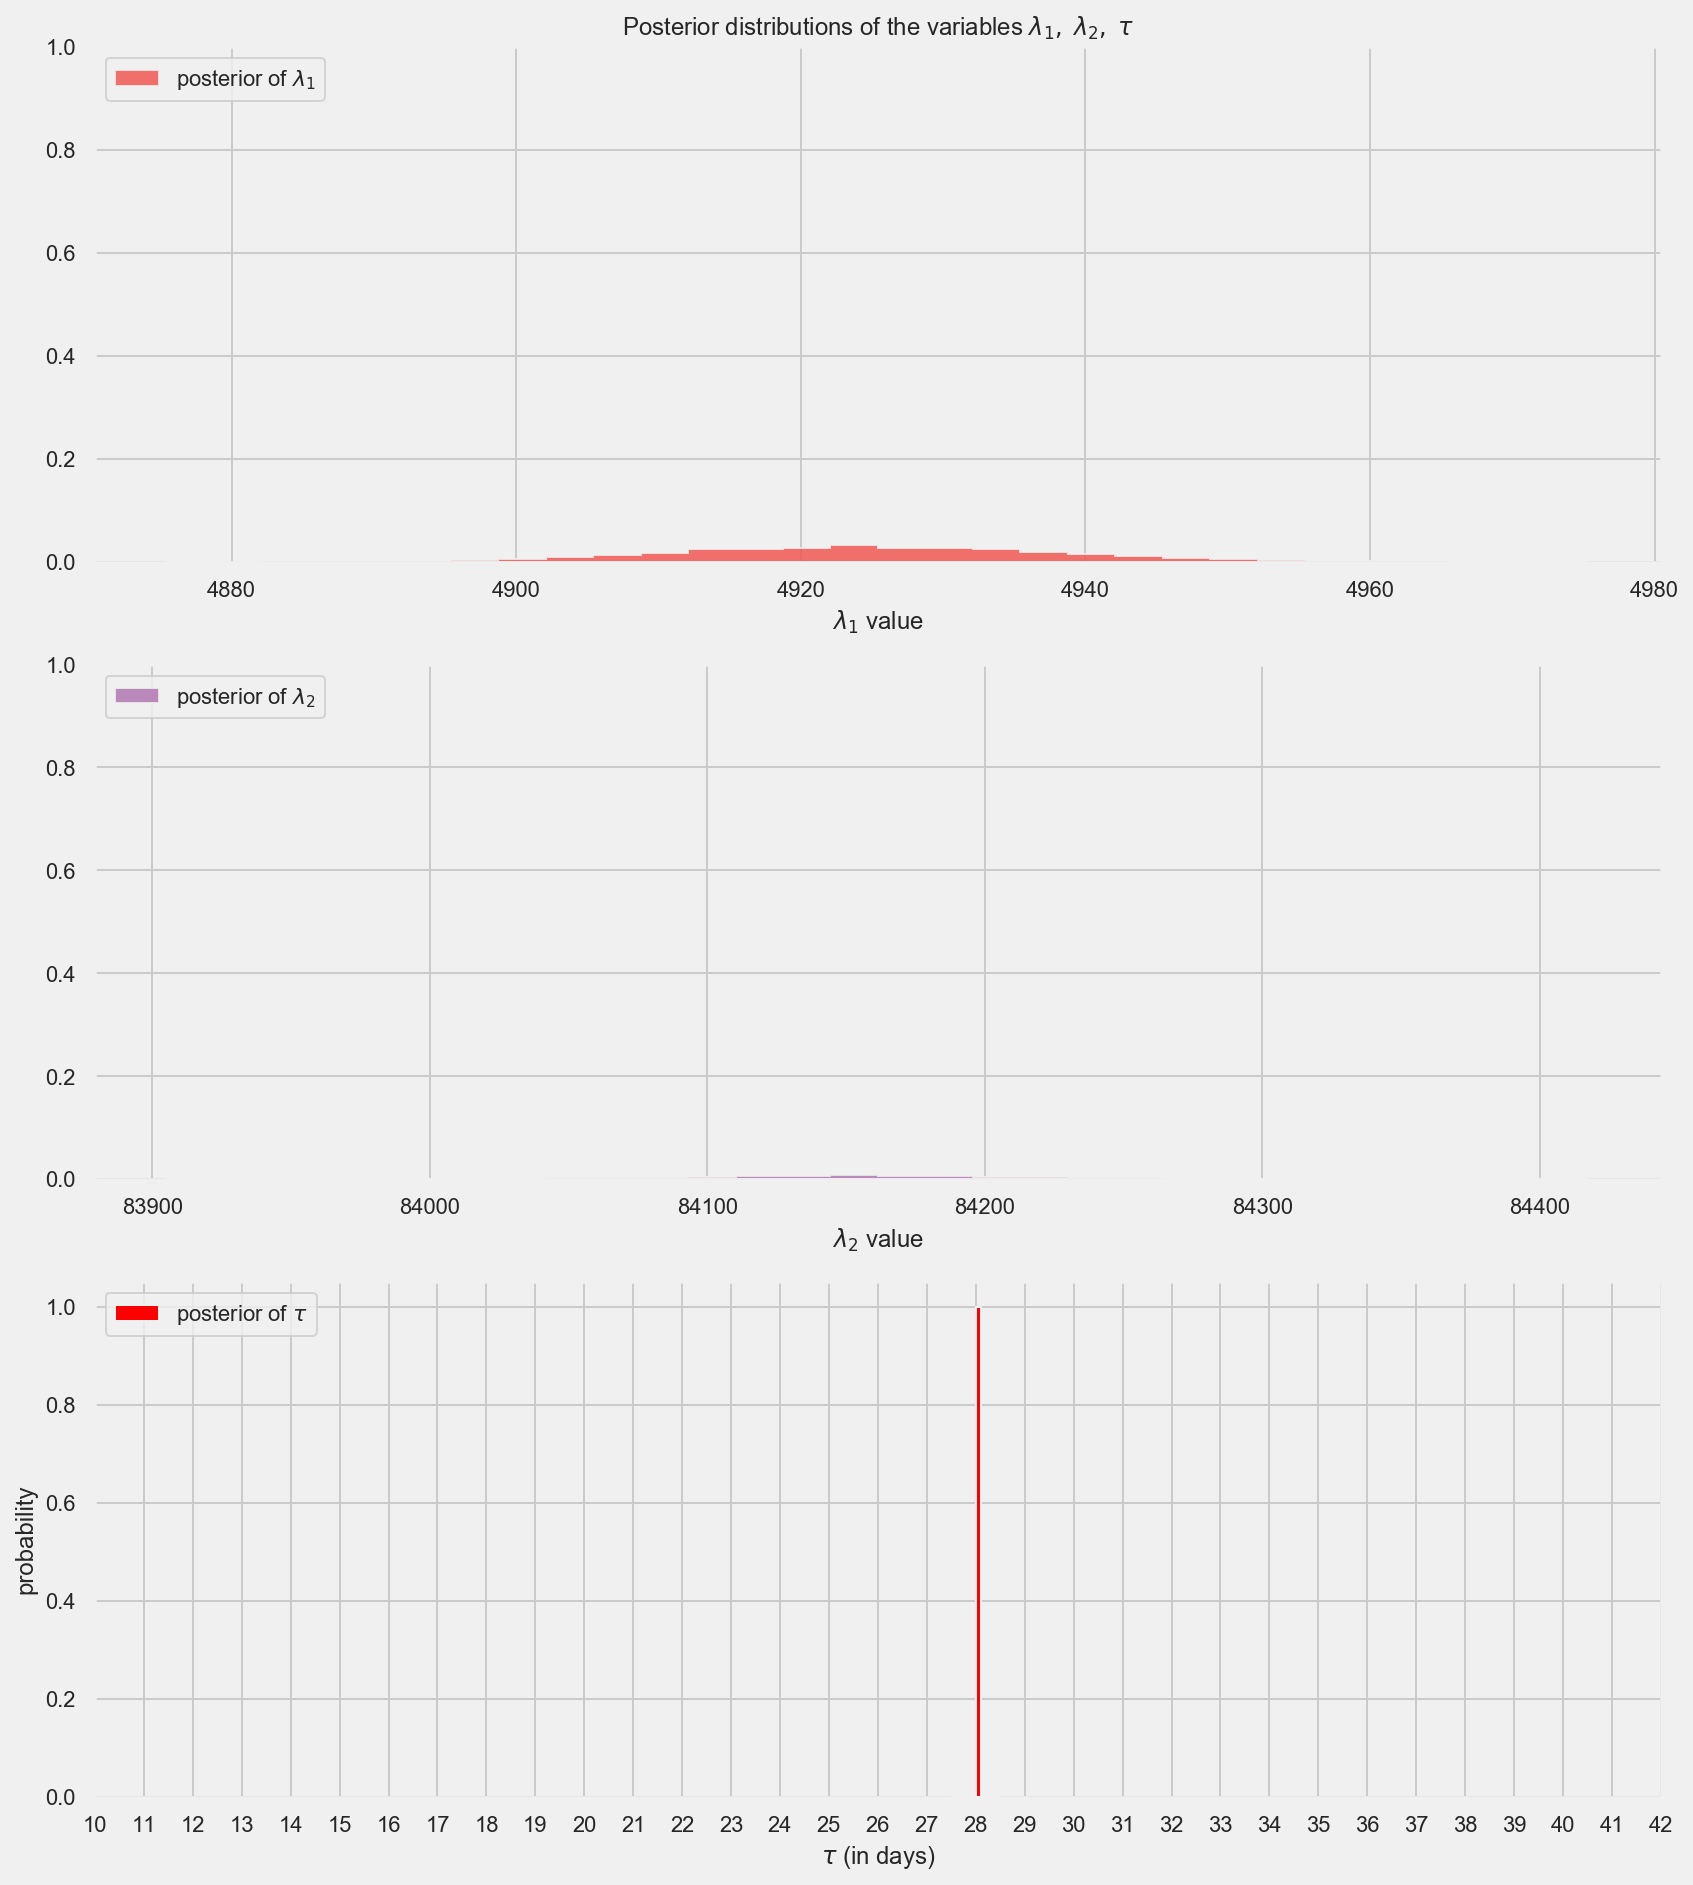

In [346]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color=TFColor[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
#plt.xlim([15, 30])
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color=TFColor[6], density=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples.numpy().astype(int), 
         alpha=1,
         label=r"posterior of $\tau$",
         color="red", 
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data[0]))

plt.legend(loc="upper left")
#plt.ylim([0, .75])
plt.xlim([10, len(count_data)-10])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

2020-03-27 00:00:00


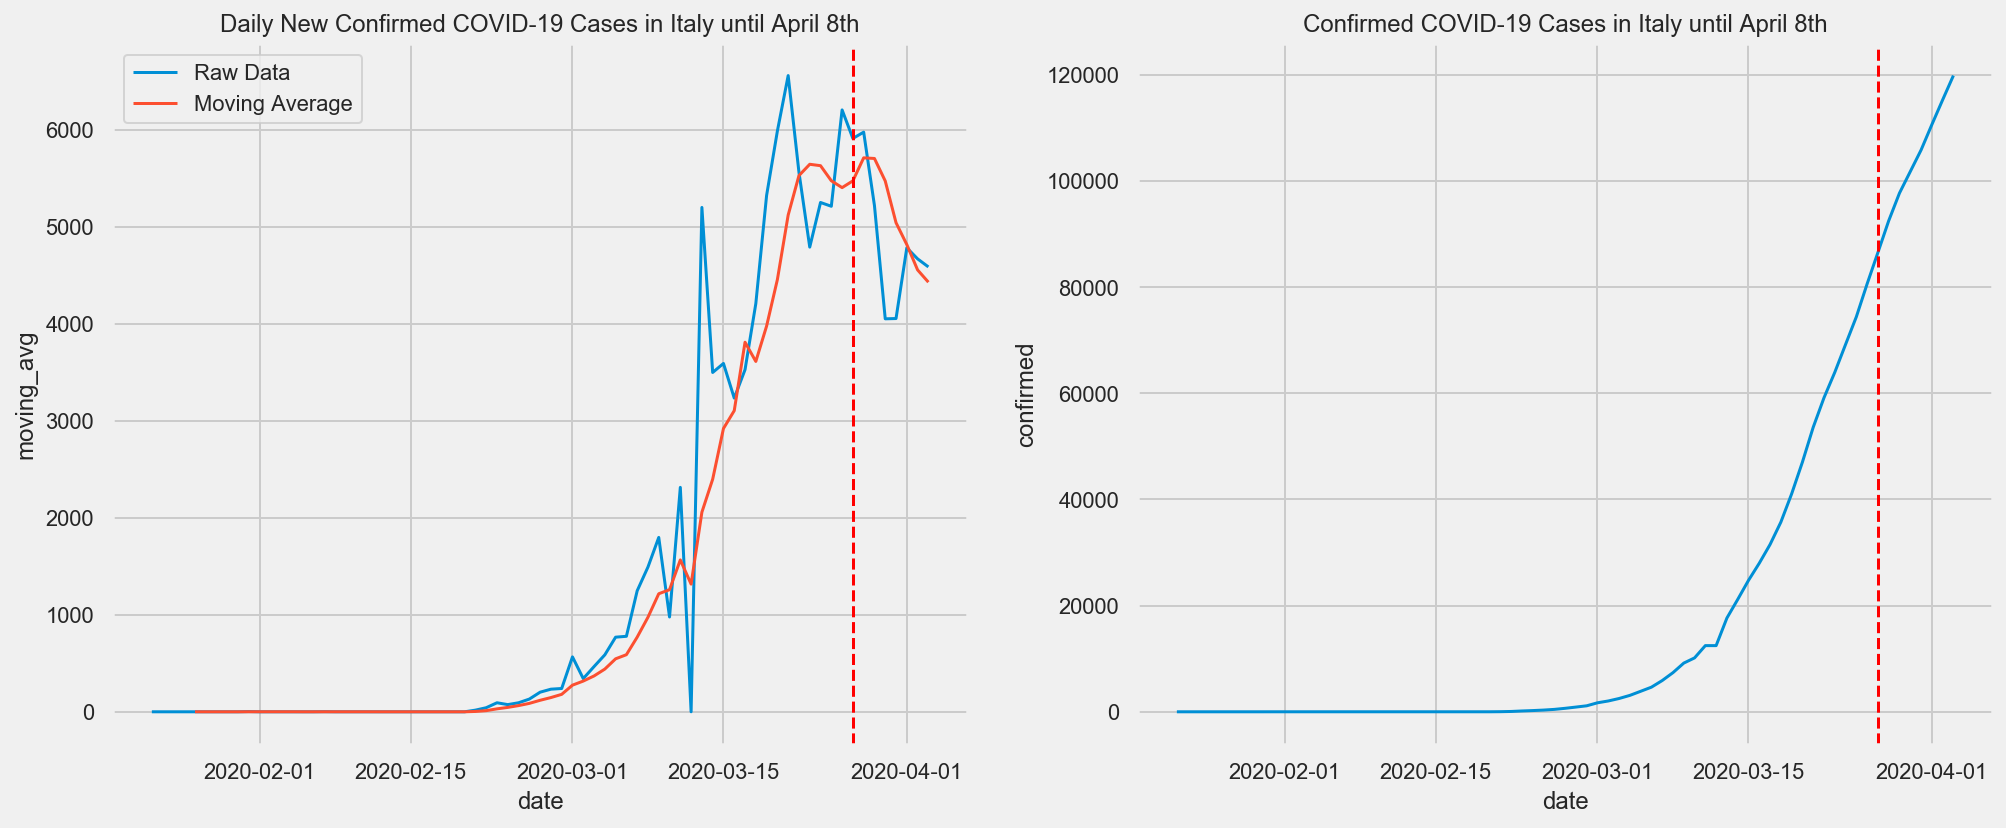

In [348]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))

# plot daily confirmed cases, along with moving average
#plt.figure(figsize=(11, 5))
sns.lineplot(x = "date", 
             y = "daily_confirmed", 
             data = italy,
             label = "Raw Data",
             ax = ax[0])

sns.lineplot(x = "date", 
             y = "moving_avg", 
             data = italy,
             label = "Moving Average",
             legend = "full",
             ax = ax[0]).set_title("Daily New Confirmed COVID-19 Cases in Italy until April 8th")

#plt.figure(figsize=(11, 5))
sns.lineplot(x="date", 
             y="confirmed", 
             data= italy,
             ax = ax[1]
            ).set_title("Confirmed COVID-19 Cases in Italy until April 8th")

ax[0].axvline(italy.date[30 + np.mean(tau_samples.numpy()).astype(int)], color="red", linestyle="--")
ax[1].axvline(italy.date[30 + np.mean(tau_samples.numpy()).astype(int)], color="red", linestyle="--")
print(italy.date[30 + np.mean(tau_samples.numpy()).astype(int)]);

## Bayesian Regression Model

Incorporate Bayesian regression with Bayesian change point analysis. 

**NOTE: Regression model isnt appropriate because the data is a time series and each point isnt observed independently**

#### Likelihood

$$y = e^{kt} + \epsilon$$

$$ln(y) \sim N (\lambda t, \sigma^2)$$

#### Priors

$$k = k_1 if \tau < t$$
$$k = k_2 if \tau >= t$$

$$k_1, k_2 \sim Exp(\alpha)$$
$$\sigma \sim p(\sigma)$$

In [5]:
# start by modelling the data using bayesian regression, no change point model 
reg_data = italy.copy().drop(["country", "deaths", "recovered", "moving_avg"], axis = 1)

# assume the virus "started" in Italy around 2020-02-21
reg_data = reg_data[reg_data.date > "2020-02-21"]

# t in the model above
reg_data["days_since_feb21"] = np.arange(reg_data.shape[0]) + 1
reg_data = reg_data.reset_index()
reg_data.head()

,index,date,confirmed,daily_confirmed,days_since_feb21
0,24,2020-02-22,62,42,1
1,25,2020-02-23,155,93,2
2,26,2020-02-24,229,74,3
3,27,2020-02-25,322,93,4
4,28,2020-02-26,453,131,5


In [6]:
# run if using daily_confirmed as a response
# there are no daily confirmed cases on March 12th, probably some sort of admin error because there are 5100 cases 
# on march 13th.
# take 2500 cases from march 13th and put them in march 12th. This will be "wrong", however hopefully any error w
num_cases = 2500
reg_data.loc[reg_data.date == "2020-03-12", "daily_confirmed"] = 2500 # add cases to march12th
reg_data.loc[reg_data.date == "2020-03-13", "daily_confirmed"] -= 2500 # subtract the cases from march13th

In [602]:
# piece 1
df = reg_data[reg_data.days_since_feb21 < 31]
x = np.array(df["days_since_feb21"]).reshape(-1, 1) # predictor is the day number, t
y = np.log(np.array(df["daily_confirmed"]).reshape(-1, 1)) # response is the number of confirmed cases

reg = LinearRegression()
_ = reg.fit(x, y)
print(reg.coef_)
print(reg.intercept_)

# piece 2
df2 = reg_data[reg_data.days_since_feb21 >= 31]
x2 = np.array(df2["days_since_feb21"]).reshape(-1, 1) # predictor is the day number, t
y2 = np.log(np.array(df2["daily_confirmed"]).reshape(-1, 1)) # response is the number of confirmed cases

reg2 = LinearRegression()
_ = reg2.fit(x2, y2)
print(reg2.coef_)
print(reg2.intercept_)

[[0.16617948]]
[4.22853251]
[[-0.01934024]]
[9.22553569]


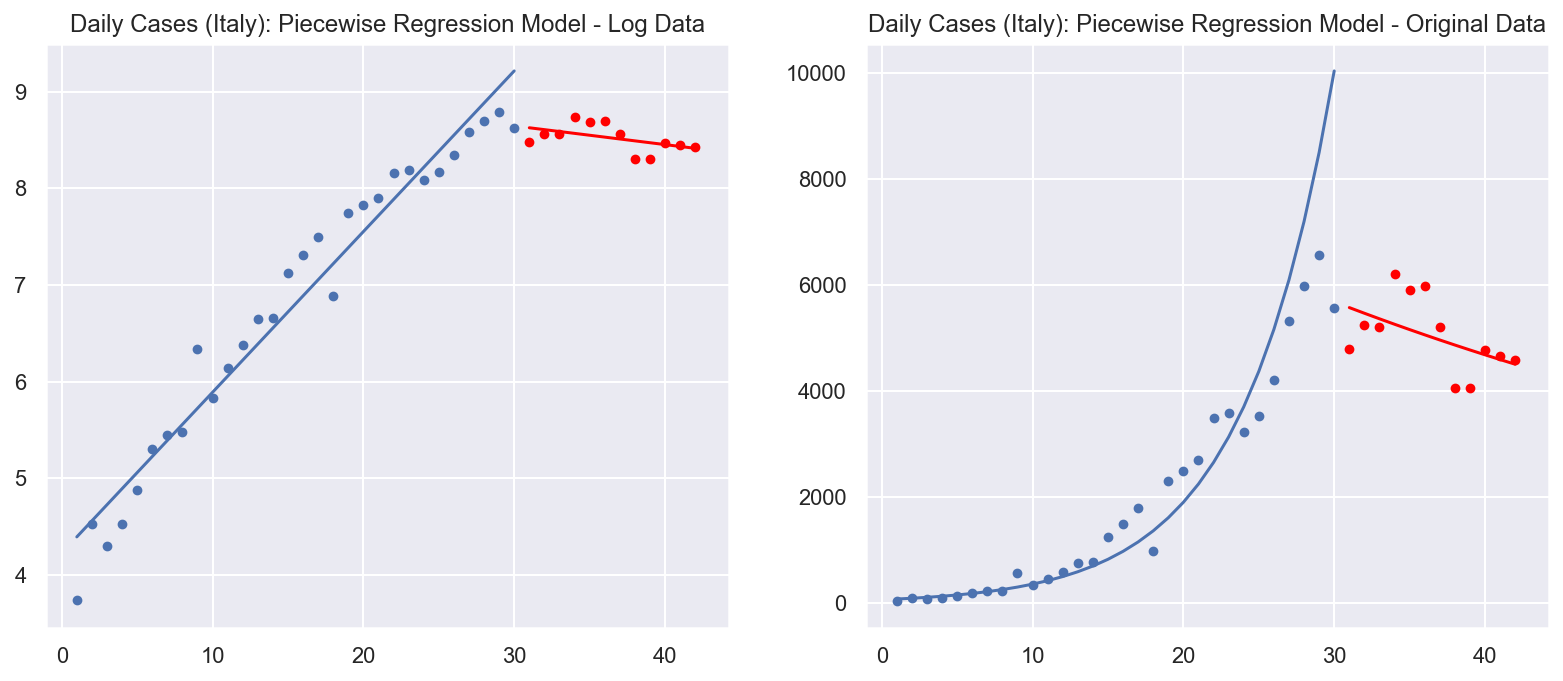

In [603]:
# plot data:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# log regression model
ax[0].scatter(x, y, s = 15);
ax[0].scatter(x2, y2, s = 15, color = "red");
ax[0].plot(x, x*reg.coef_[0][0] + reg.intercept_) 
ax[0].plot(x2, x2*reg2.coef_[0][0] + reg2.intercept_, color = "red") 
ax[0].set(title = "Daily Cases (Italy): Piecewise Regression Model - Log Data")

ax[1].scatter(x, np.exp(y), s = 15)
ax[1].scatter(x2, np.exp(y2), s = 15, color = "red")
ax[1].plot(x, np.exp(x*reg.coef_[0][0] + reg.intercept_))
ax[1].plot(x2, np.exp(x2*reg2.coef_[0][0] + reg2.intercept_), color = "red");
ax[1].set(title = "Daily Cases (Italy): Piecewise Regression Model - Original Data");

### Incorporate Change Point Model 

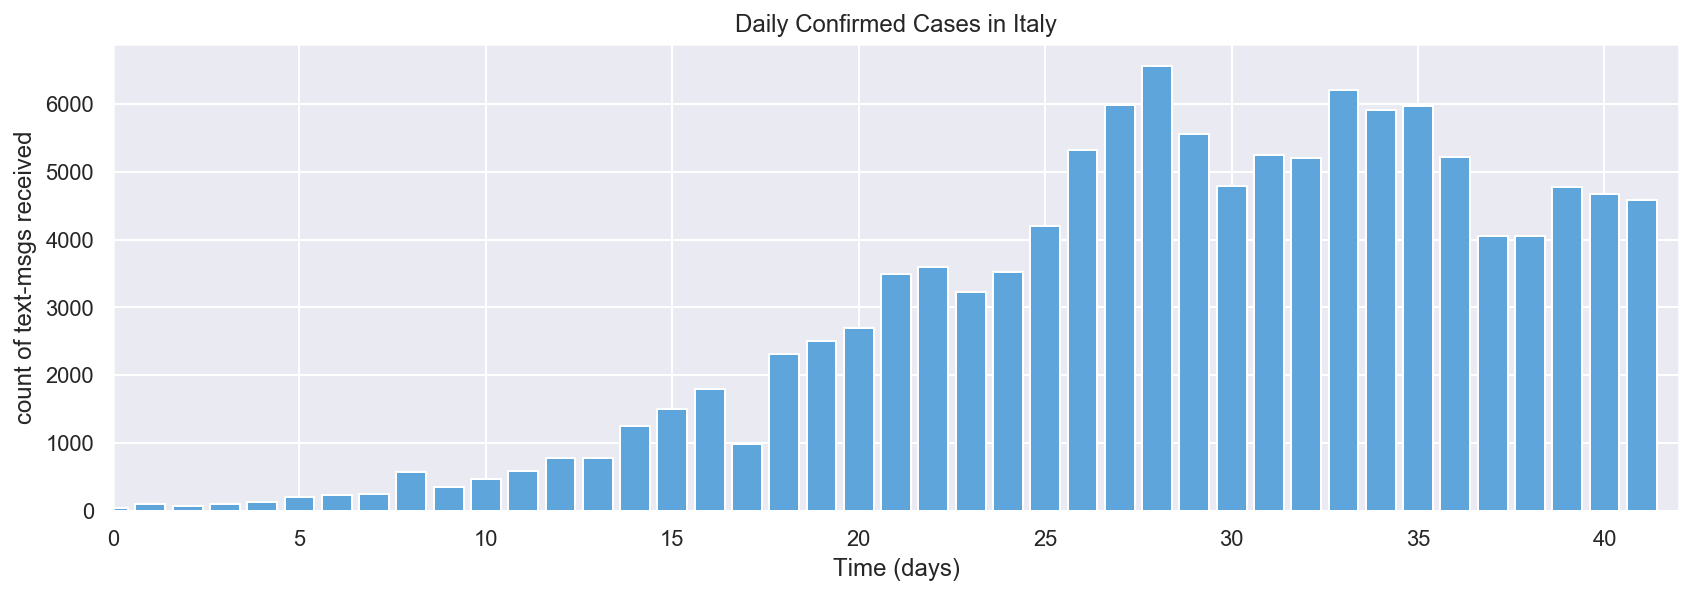

In [604]:
count_data = tf.constant(reg_data.daily_confirmed, dtype = tf.float32)

n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0],dtype=tf.int32)

# Visualizing the Results
plt.figure(figsize=(12.5, 4))
plt.bar(days.numpy(), count_data, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Daily Confirmed Cases in Italy")
plt.xlim(0, n_count_data[0].numpy());

In [631]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    alpha = (1. / tf.reduce_mean(count_data)) 
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    #rv_sigma = tfd.Uniform(low = 0, high = 5)
    rv_tau = tfd.Beta(4, 2)
 
    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(tau * tf.cast(tf.size(count_data), 
                                       dtype=tf.float32) <= tf.cast(tf.range(tf.size(count_data)), 
                                                                                         dtype=tf.float32), 
                         dtype=tf.int32))

    # likelihood
    rv_observation = tfd.LogNormal(loc=lambda_, scale = 50)
 
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         #+ rv_sigma.log_prob(sigma)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )


# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau) #, sigma)

In [632]:
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
    return tfp.mcmc.sample_chain(*args, **kwargs)

num_burnin_steps = 5000
num_results = 20000

# Set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
    #2 * tf.ones([], dtype=tf.float32, name="init_sigma"),
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
    #tfp.bijectors.Exp(),
]

step_size = 0.2

kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))


# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
#    posterior_sigma,
], kernel_results = graph_sample_chain(
    num_results = num_results,
    num_burnin_steps = num_burnin_steps,
    current_state = initial_chain_state,
    kernel = kernel)
    
tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data), dtype=tf.float32))

In [571]:
print("acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(kernel_results.inner_results.inner_results.is_accepted,dtype=tf.float32))))
print("final step size: {}".format(
    tf.reduce_mean(kernel_results.inner_results.inner_results.accepted_results.step_size[-100:])))

acceptance rate: 0.6751000285148621
final step size: 0.42604348063468933


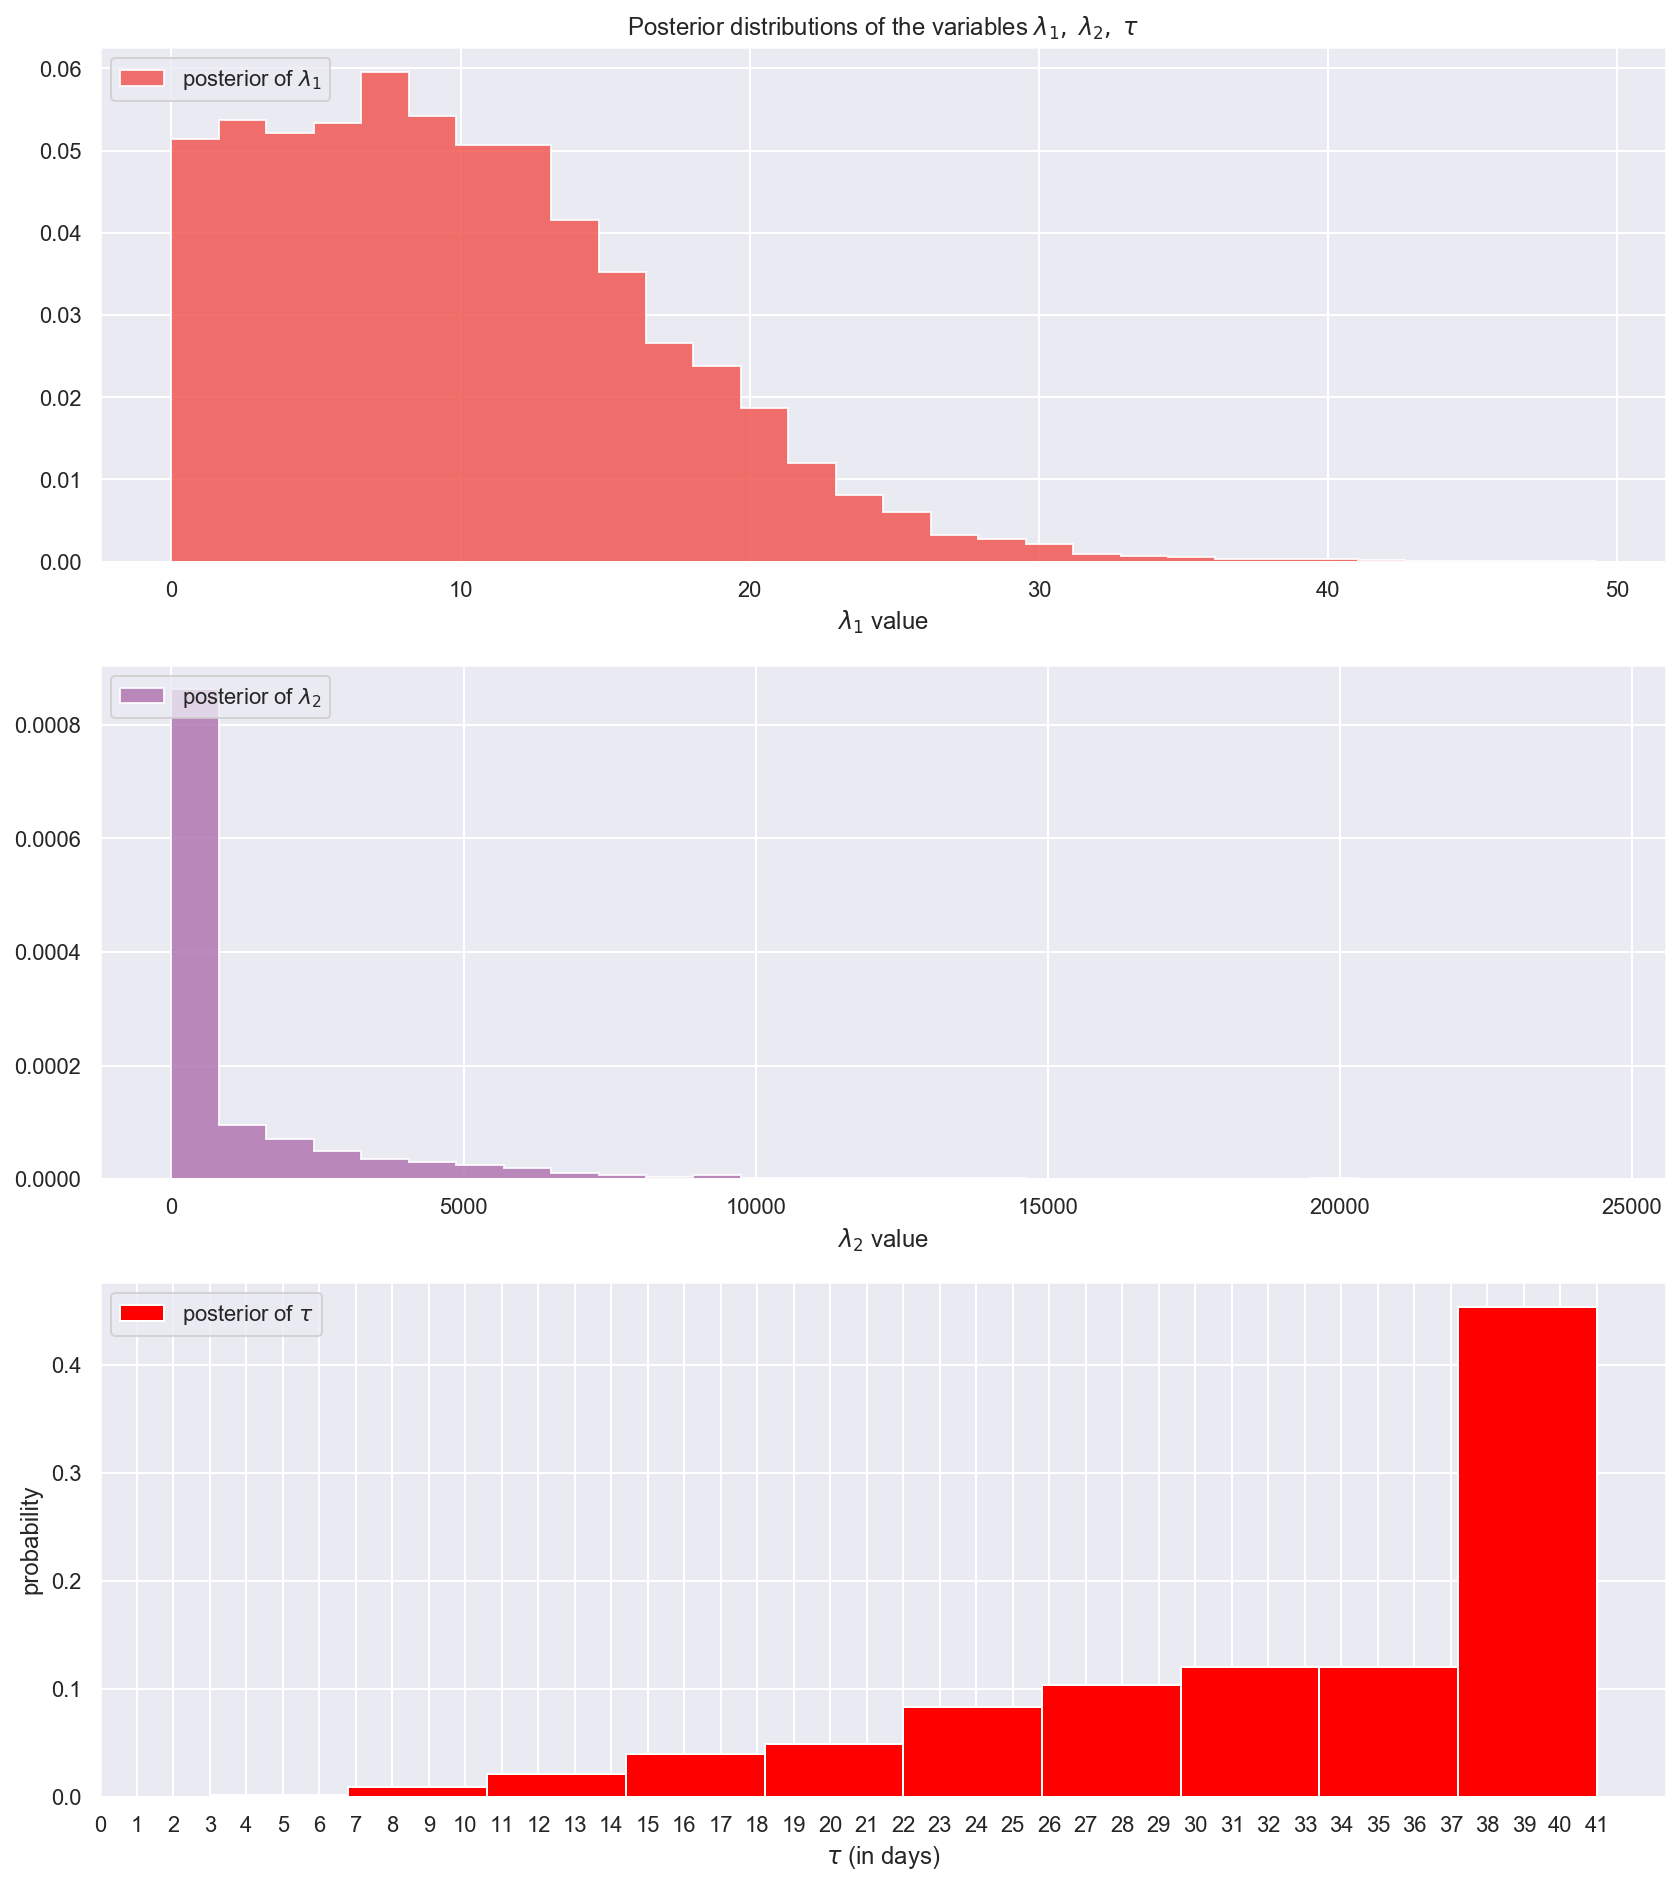

In [572]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color=TFColor[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
plt.hist(lambda_2_samples, 
         histtype='stepfilled', 
         bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", 
         color=TFColor[6], density=True)
plt.legend(loc="upper left")
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples.numpy().astype(int), 
         alpha=1,
         label=r"posterior of $\tau$",
         color="red", 
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data[0]))

plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

In [573]:
print("mean: ", np.mean(tau_samples.numpy()))
print("median: ", np.median(tau_samples.numpy()))
print("mode: ", stats.mode(tau_samples.numpy()).mode[0])

mean:  33.3123
median:  36.0
mode:  41.0


2020-03-29 00:00:00


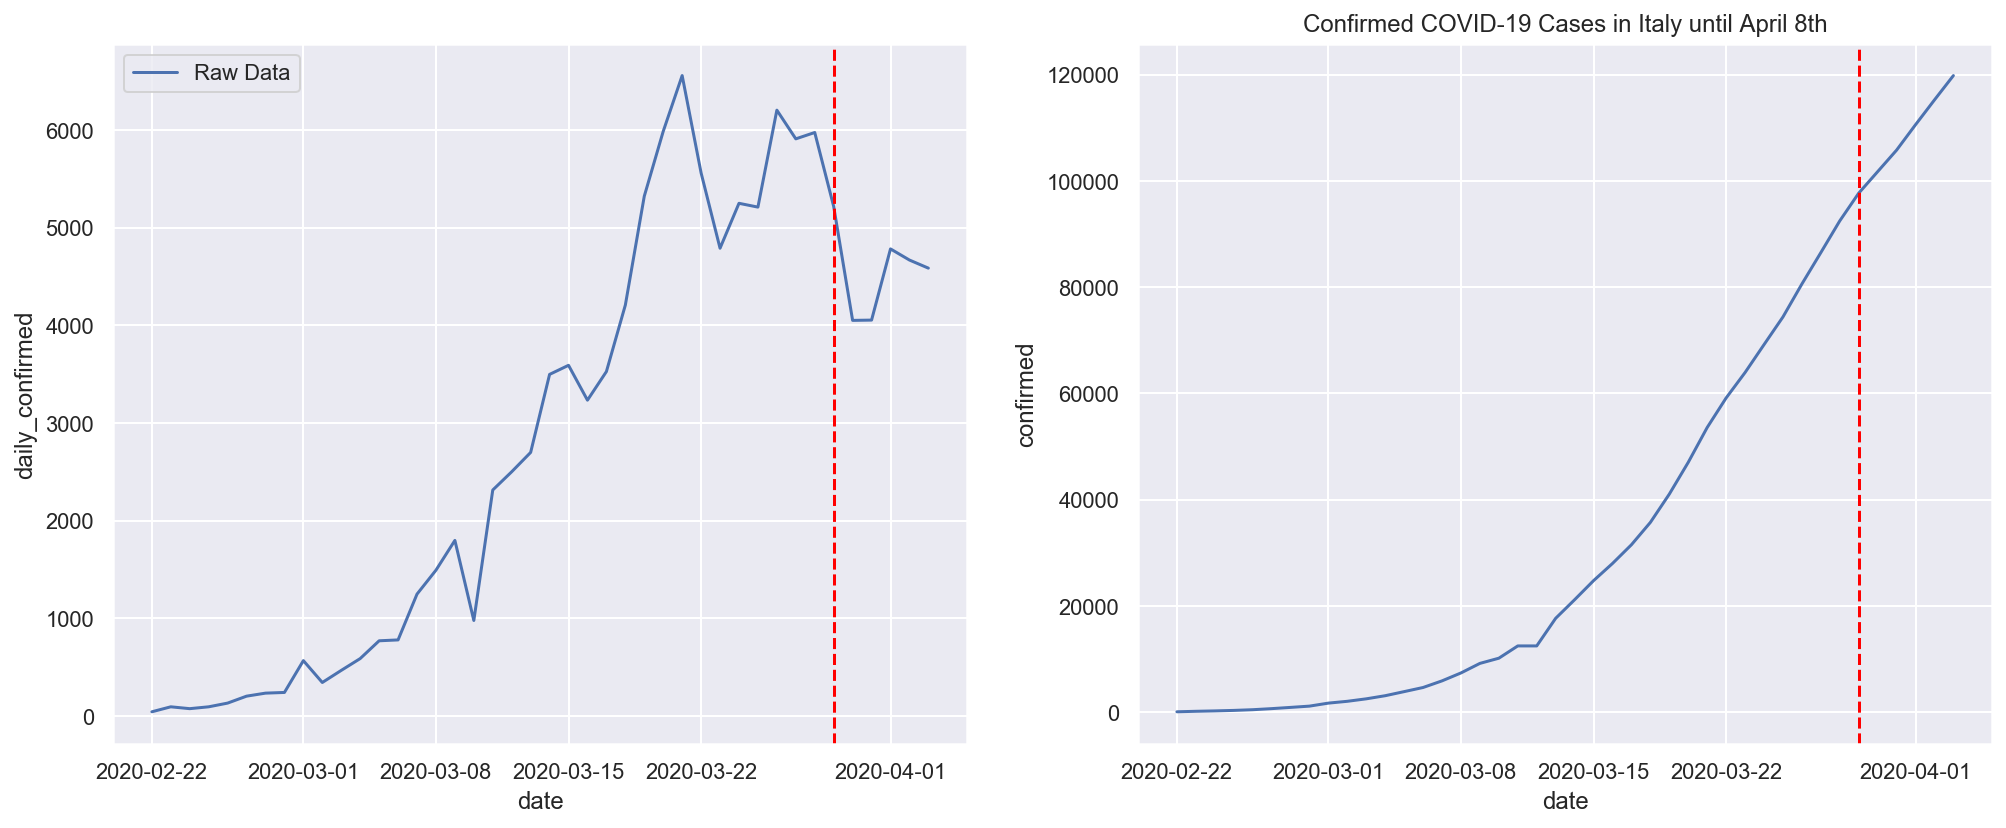

In [574]:
date_ind = np.median(tau_samples.numpy()).astype(int)

fig, ax = plt.subplots(1,2, figsize=(15, 6))

# plot daily confirmed cases, along with moving average
sns.lineplot(x = "date", 
             y = "daily_confirmed", 
             data = reg_data,
             label = "Raw Data",
             ax = ax[0])

#plt.figure(figsize=(11, 5))
sns.lineplot(x="date", 
             y="confirmed", 
             data= reg_data,
             ax = ax[1]
            ).set_title("Confirmed COVID-19 Cases in Italy until April 8th")

ax[0].axvline(reg_data.reset_index().date[date_ind], color="red", linestyle="--")
ax[1].axvline(reg_data.reset_index().date[date_ind], color="red", linestyle="--")
print(reg_data.reset_index().date[date_ind]);

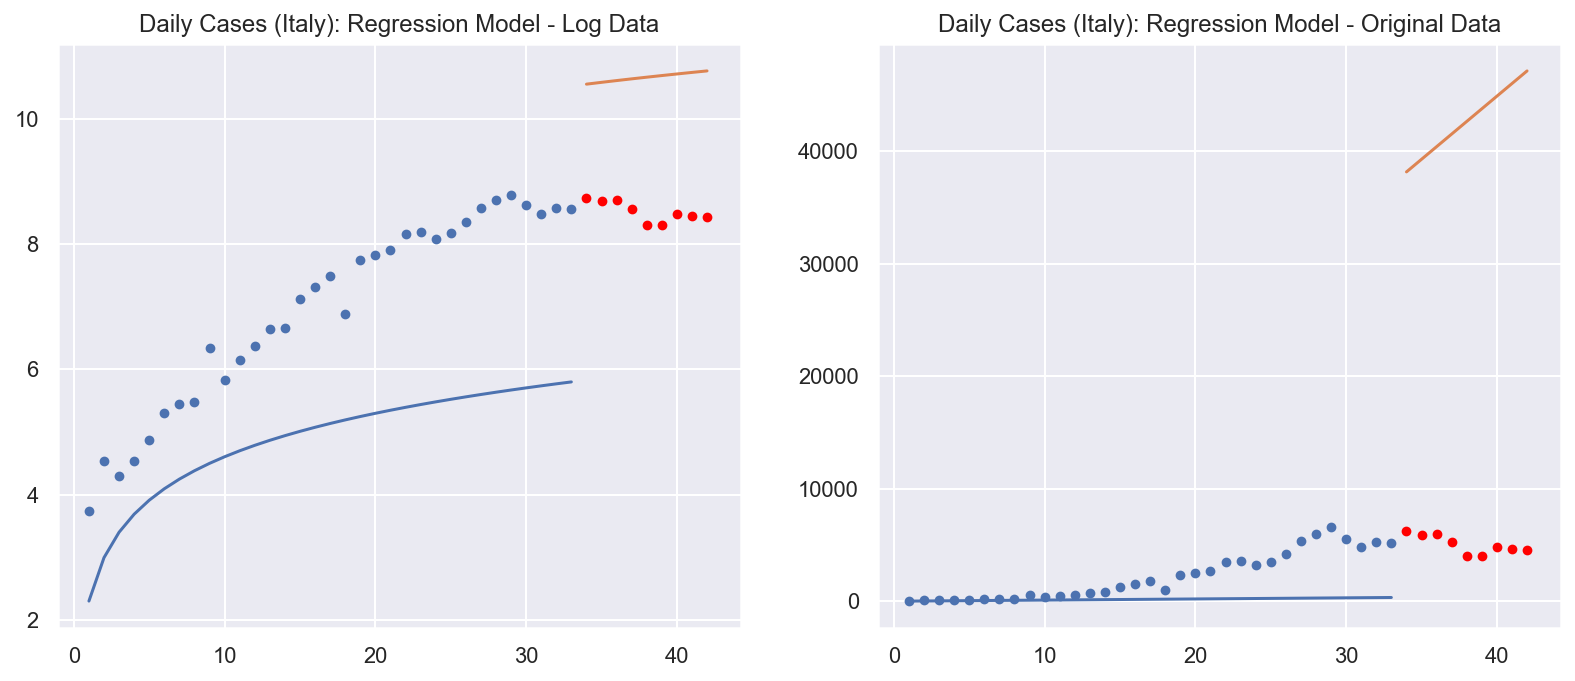

In [626]:
tau_post = int(np.mean(tau_samples.numpy())) # posterior mean for tau
lambda_1_post = int(np.mean(lambda_1_samples.numpy())) # posterior mean for lambda 1
lambda_2_post = int(np.mean(lambda_2_samples.numpy())) # posterior mean for lambda 2

# plot data:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# log regression model
ax[0].scatter(y = np.log(reg_data.daily_confirmed[:tau_post]), x = reg_data.days_since_feb21[:tau_post], s = 15);
ax[0].scatter(y = np.log(reg_data.daily_confirmed[tau_post:]), x = reg_data.days_since_feb21[tau_post:], s = 15, color = "red");
ax[0].plot(reg_data.days_since_feb21[:tau_post], np.log(reg_data.days_since_feb21[:tau_post]*lambda_1_post)) # t < tau_post
ax[0].plot(reg_data.days_since_feb21[tau_post:], np.log(reg_data.days_since_feb21[tau_post:]*lambda_2_post)) # t > tau_post
ax[0].set(title = "Daily Cases (Italy): Regression Model - Log Data")

ax[1].scatter(y = reg_data.daily_confirmed[:tau_post], x = reg_data.days_since_feb21[:tau_post], s = 15);
ax[1].scatter(y = reg_data.daily_confirmed[tau_post:], x = reg_data.days_since_feb21[tau_post:], s = 15, color = "red");
ax[1].plot(reg_data.days_since_feb21[:tau_post], reg_data.days_since_feb21[:tau_post]*lambda_1_post) # t < tau_post
ax[1].plot(reg_data.days_since_feb21[tau_post:], reg_data.days_since_feb21[tau_post:]*lambda_2_post) # t > tau_post
ax[1].set(title = "Daily Cases (Italy): Regression Model - Original Data");

## Move to Pyro

In [125]:
import torch

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule

from pyro.nn import PyroSample
from pyro.infer import MCMC, NUTS, HMC

In [137]:
def BayesianChangePointRegression (data) :
    # declare priors
    lambda_1 = pyro.sample("lambda_1", dist.Normal(loc = 0, scale = 10))
    lambda_2 = pyro.sample("lambda_2", dist.Normal(loc = 0, scale = 10))
    tau = pyro.sample("tau", dist.Beta(4, 2)) 
    sigma = pyro.sample("sigma", dist.Uniform(0, 5)) 
    
    # choose lambda based on \tau
    tau_indices = torch.tensor(tau * len(data) <= torch.tensor(np.arange(len(data))).reshape(-1), dtype = int)
    lambda_select = torch.tensor([lambda_1, lambda_2]).reshape(-1)
    lambda_ = torch.index_select(lambda_select, 
                                 dim = 0,
                                 index = tau_indices)
    
    #t = torch.tensor([0,0,0,100,100,100,100], dtype = float)
    #pyro.sample("obhouhis", dist.Normal(t, torch.ones(len(t))))
    
    # posterior 
    obs = pyro.sample("obs", dist.Normal(lambda_, torch.ones(len(data)) * sigma), obs = data) 
    return obs

In [138]:
y_data = np.log(torch.tensor(reg_data["daily_confirmed"].values, dtype=torch.float))

nuts_kernel = NUTS(BayesianChangePointRegression)

mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50)
mcmc.run(y_data)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
hmc_samples.keys()

Sample: 100%|██████████| 150/150 [05:16,  2.11s/it, step size=5.12e-04, acc. prob=0.701]


dict_keys(['lambda_1', 'lambda_2', 'tau', 'sigma'])

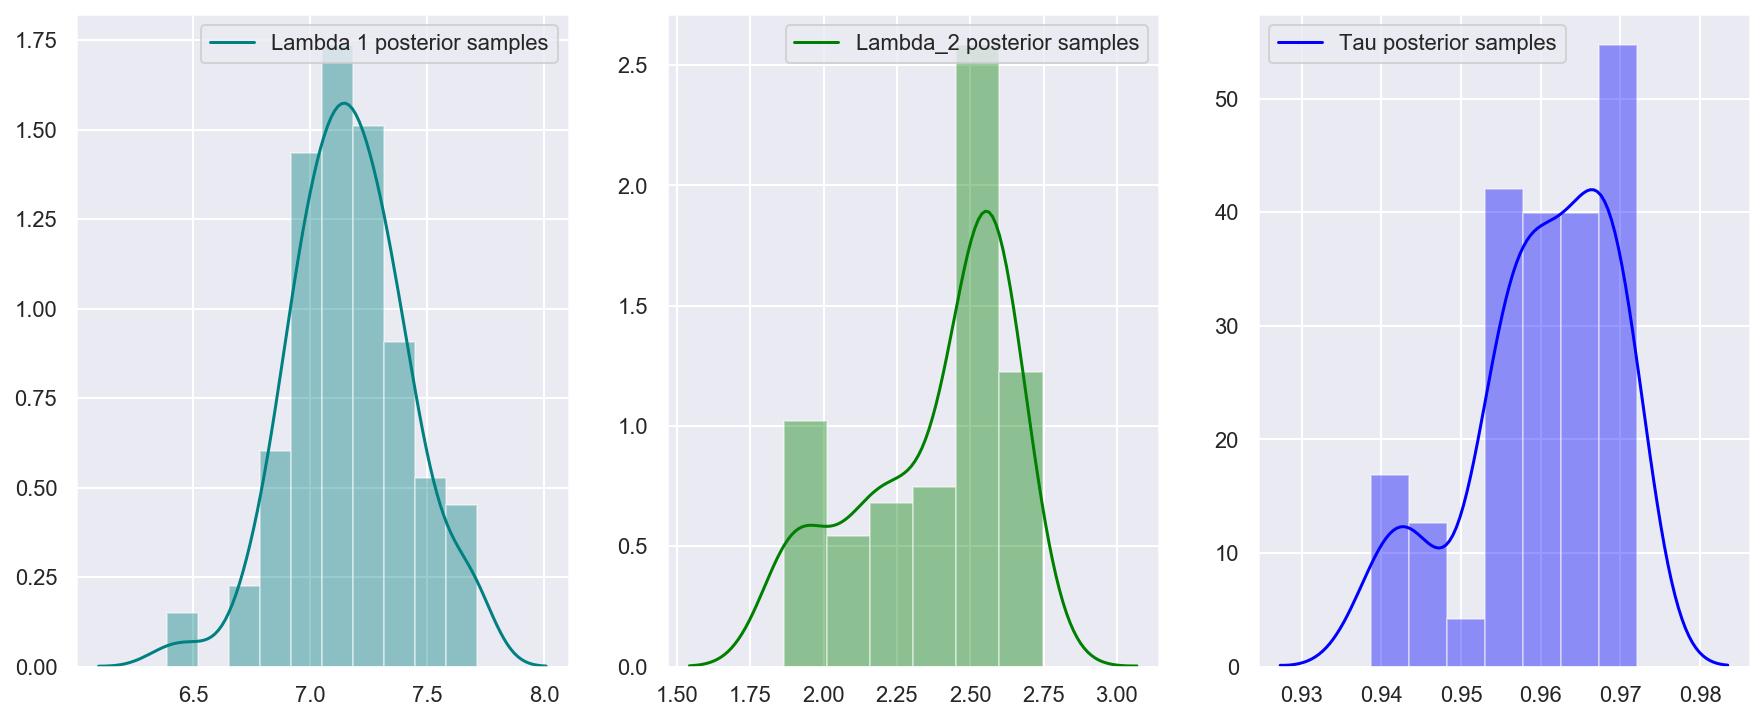

In [145]:
fig, ax = plt.subplots(1,3, figsize=(15, 6))

sns.distplot(hmc_samples["lambda_1"], 
             kde_kws = {"label": "Lambda 1 posterior samples"}, 
             color = "teal",
             norm_hist = True,
             kde = True,
             ax = ax[0]);

sns.distplot(hmc_samples["lambda_2"], 
             kde_kws = {"label": "Lambda_2 posterior samples"}, 
             color = "green",
             norm_hist = True,
             kde = True,
             ax = ax[1]);

sns.distplot(hmc_samples["tau"], 
             kde_kws = {"label": "Tau posterior samples"}, 
             color = "blue",
             norm_hist = True,
             kde = True,
             ax = ax[2]);

/Users/jonny/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


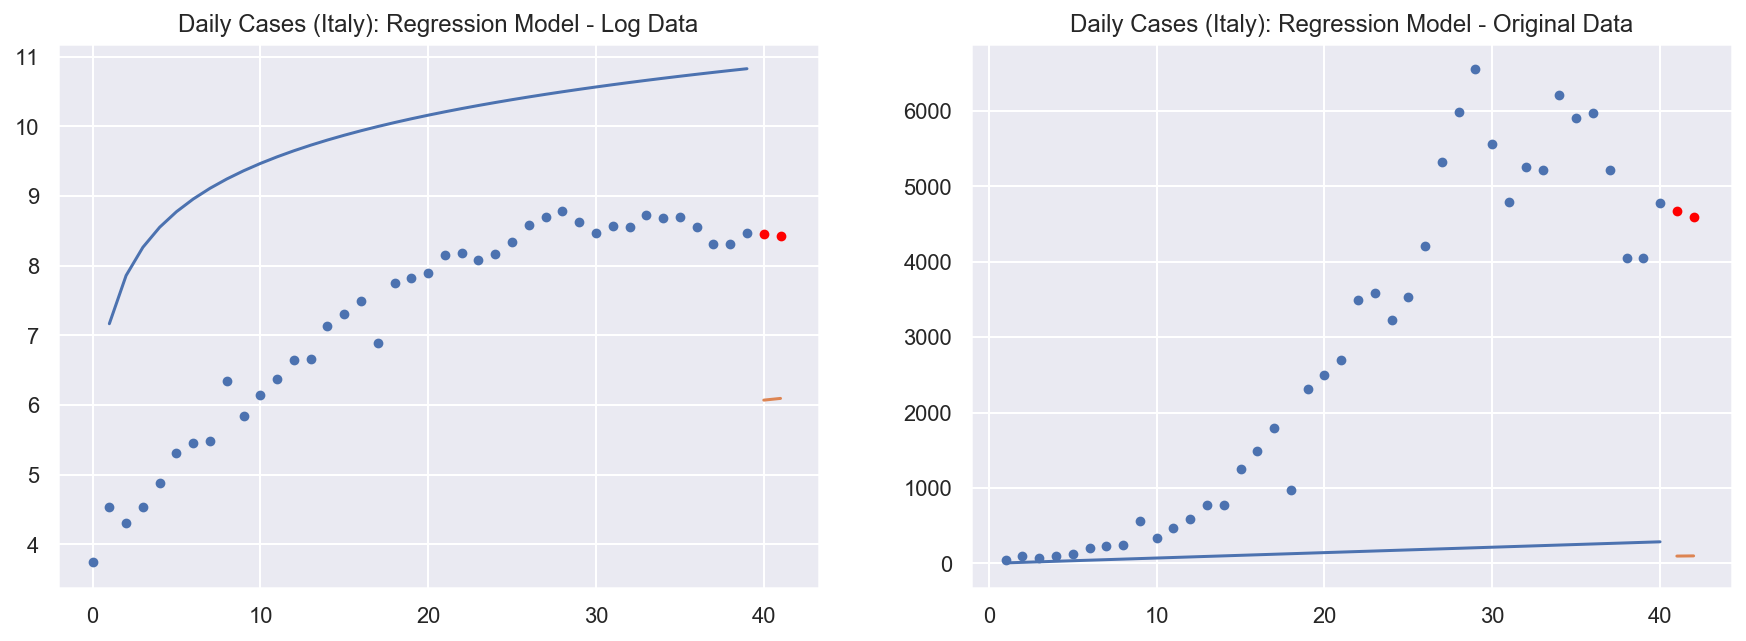

In [152]:
tau_post = int(np.mean(hmc_samples["tau"]) * len(y_data)) # posterior mean for tau
lambda_1_post = np.mean(hmc_samples["lambda_1"]) # posterior mean for lambda 1
lambda_2_post = np.mean(hmc_samples["lambda_2"]) # posterior mean for lambda 2

x_pre_tau = np.arange(tau_post)
x_post_tau = np.arange(tau_post, len(y_data))

# plot data:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# log regression model
ax[0].scatter(y = y_data[:tau_post], x = x_pre_tau, s = 15);
ax[0].scatter(y = y_data[tau_post:], x = x_post_tau, s = 15, color = "red");

ax[0].plot(x_pre_tau, np.log(x_pre_tau) + lambda_1_post) 
ax[0].plot(x_post_tau, np.log(x_post_tau) + lambda_2_post) 
ax[0].set(title = "Daily Cases (Italy): Regression Model - Log Data")


ax[1].scatter(y = reg_data.daily_confirmed[:tau_post], 
              x = reg_data.days_since_feb21[:tau_post], s = 15);
ax[1].scatter(y = reg_data.daily_confirmed[tau_post:], 
              x = reg_data.days_since_feb21[tau_post:], s = 15, color = "red");
ax[1].plot(reg_data.days_since_feb21[:tau_post], reg_data.days_since_feb21[:tau_post]*lambda_1_post) # t < tau_post
ax[1].plot(reg_data.days_since_feb21[tau_post:], reg_data.days_since_feb21[tau_post:]*lambda_2_post) # t > tau_post
ax[1].set(title = "Daily Cases (Italy): Regression Model - Original Data");

2020-04-02 00:00:00


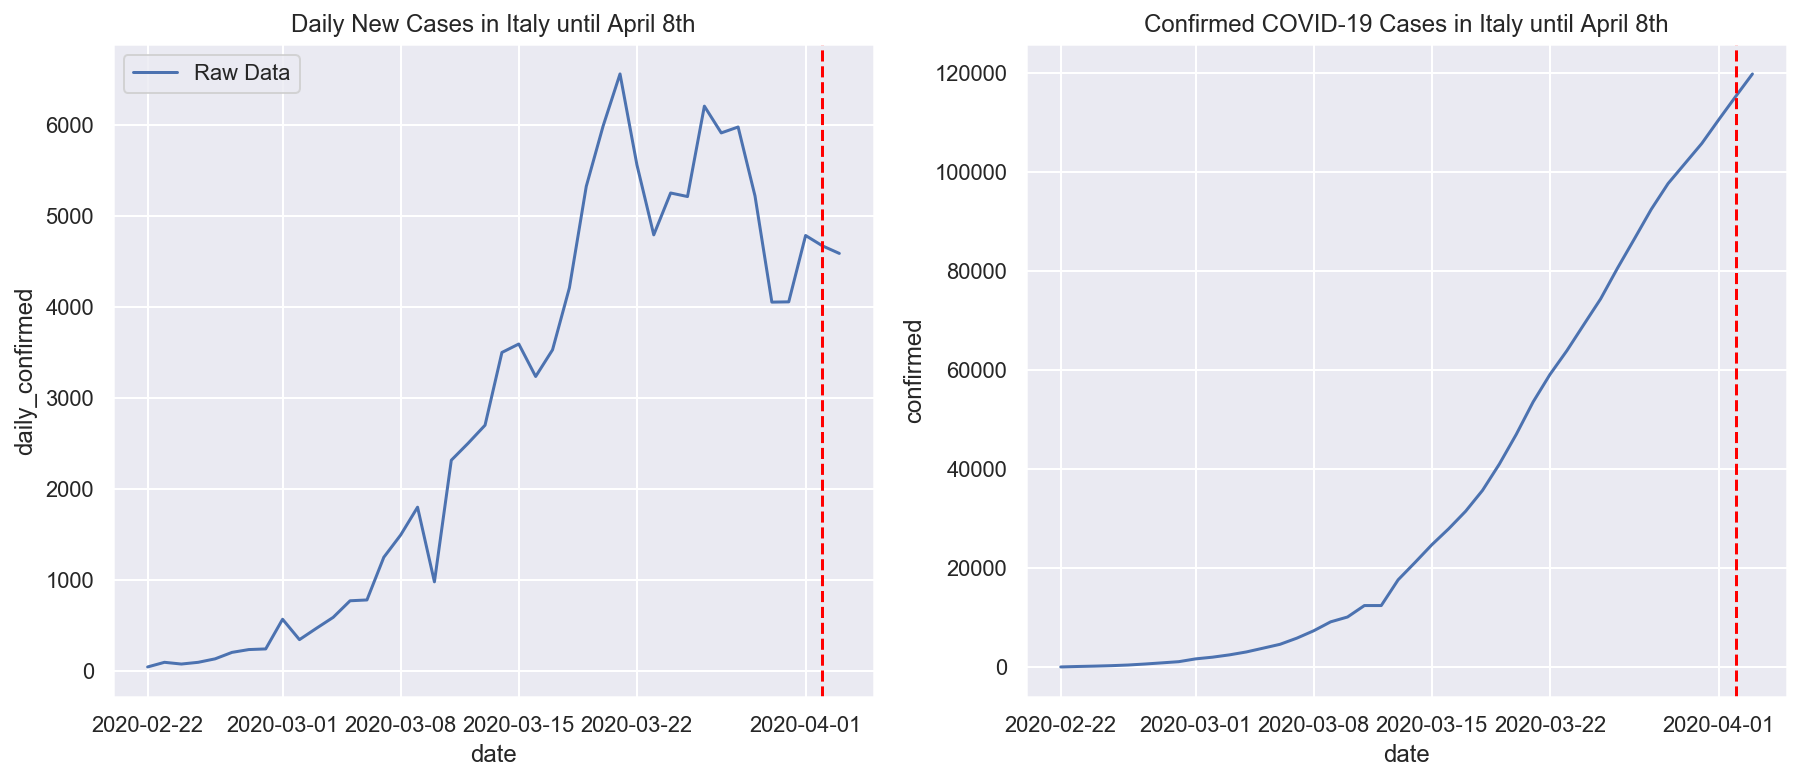

In [154]:
date_ind = int(np.mean(hmc_samples["tau"]) * len(y_data)) # posterior mean for tau

fig, ax = plt.subplots(1,2, figsize=(15, 6))

# plot daily confirmed cases, along with moving average
sns.lineplot(x = "date", 
             y = "daily_confirmed", 
             data = reg_data,
             label = "Raw Data",
             ax = ax[0]).set_title("Daily New Cases in Italy until April 8th")

#plt.figure(figsize=(11, 5))
sns.lineplot(x="date", 
             y="confirmed", 
             data= reg_data,
             ax = ax[1]
            ).set_title("Confirmed COVID-19 Cases in Italy until April 8th")

ax[0].axvline(reg_data.reset_index().date[date_ind], color="red", linestyle="--")
ax[1].axvline(reg_data.reset_index().date[date_ind], color="red", linestyle="--")
print(reg_data.reset_index().date[date_ind]);